# On-The-Fly (OTF) Data Reduction - Part 1

This notebook shows how to use `dysh` to calibrate and grid an *On-The-Fly* (OTF) observation. See Mangum et al. (2007) in https://ui.adsabs.harvard.edu/abs/2007A%26A...474..679M for the background on this method.

This more complex observation is not reduced with one simple command in dysh, but is usually two steps: 

1. The first step is calibration, where the calibrated spectra are written to an SDFITS file. This can be done in dysh, usually in a loop, one spectrum a time. Baseline subtraction can be done here, but users should be aware how well a baseline model can be applied, which is an issue we will show below.

2. The second step takes these spectra and write
them to a FITS cube. For this there are several third-party tools available, there is nothing in dysh yet to cover this.  Equally so, you may depend on baseline subtraction in the image cube instead of the scans.

In [1]:
from pathlib import Path
import astropy.units as u
from dysh.util.download import from_url
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.files import dysh_data

from dysh.spectra import ScanBlock

## Data Retrieval

Download the example SDFITS data, if necessary. or rely on `$DYSH_DATA`

In [2]:
# example="otf1" also works
filename = dysh_data(example='mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits')

#url = "http://www.gb.nrao.edu/dysh/example_data/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits"
#savepath = Path.cwd() / "data"
#filename = from_url(url, savepath)

print(filename)

/home/teuben/GBT/dysh_data/example_data/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits


In [3]:
sdfits = GBTFITSLoad(filename)

Flags were created from existing flag files. Use GBTFITSLoad.flags.show() to see them.


In [4]:
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,3C286,0.0,OnOff,1,1.6168,1.420406,5,2,13,1,248.365704,72.55312
1,7,3C286,0.0,OnOff,2,1.6168,1.420406,5,2,13,1,250.038525,73.677706
2,8,SgrB2M,57.0,Track,1,1.6168,1.420406,5,2,61,1,142.384473,12.254537
3,9,W33B,64.0,Track,1,1.6168,1.420406,5,2,61,1,132.205692,17.97864
4,10,G30.589-0.044,38.0,Track,1,1.6168,1.420406,5,2,61,1,115.481079,25.552326
5,11,G31.412+0.307,97.0,Track,1,1.6168,1.420406,5,2,61,1,115.803415,27.09864
6,12,G35.577-0.029,49.0,Track,1,1.6168,1.420406,5,2,61,1,112.31392,29.033662
7,13,G40.622-0.137,32.0,Track,1,1.6168,1.420406,5,2,61,1,107.77357,31.315933
8,14,NGC6946,45.0,DecLatMap,1,1.6168,1.420406,5,2,61,1,38.962631,41.364443
9,15,NGC6946,45.0,DecLatMap,2,1.6168,1.420406,5,2,61,1,38.991018,41.44875


In this particular observation the OTF slew over the galaxy NGC6946 in scans 14-26, followed by an Off position scan. Each **SCAN**, in this case, corresponds to a row, with 61 integrations as the telescope slews slowly over the sky.


Instead of the classical OnOff reduction with `getps`, we can use `getsigref` to refer to scan 27 as the common Off.


## Data Trimming?

Below, in the `Data Reduction` cell, you will see a loop over scans that takes over two minutes, but by trimming the input sdfits file to a smaller file with just the scans we need, this loop can go down to 10 seconds.  Hopefully in the near future we can bring down the processing time on the full data as well.  For now, suffer a bit, or execute the next cell to provide a short-cut sdfits file.

Incidentally, the overhead to create this shortcut file is just about 5 secs! There is also no harm to accidentally re-execute the cell.


In [5]:
if True:
    #   create shortcut and reload that shortcut with just 14 scans
    sdfits.write("otf1_small.fits", scan=list(range(14,28)), fdnum=0, plnum=[0,1], ifnum=0, overwrite=True)

    sdfits = GBTFITSLoad('otf1_small.fits')
    sdfits.summary()

 ID    TAG                  SCAN               IFNUM PLNUM FDNUM # SELECTED
--- --------- -------------------------------- ----- ----- ----- ----------
  0 964a90461 [14,15,16,17,18...3,24,25,26,27]     0 [0,1]     0       3416


## Data Reduction

Here we define the selections needed for the HI line in NGC6946.

In [6]:
ifnum = 0        # needs to be 0, where the 21cm signal is (there are 5 IF's in the full data(
plnum = [0,1]    # pick 0 and 1, they will be averaged. or just pick one to speed up the code
fdnum = 0        # only one feed in this dataset
nint  = 61       # nunber of integrations per scan. we will use all of them, and get the OFF from another scan
ref   = 27                    # the reference ("OFF") scan
scans = list(range(14,27))    # the source ("ON") scans

In [7]:
%%time 

sb = ScanBlock()
for s in scans:
    for p in plnum:
        print(f"Working on scan {s} pol {p}")
        sb1 =  sdfits.getsigref(scan=s, ref=ref, fdnum=fdnum, ifnum=ifnum, plnum=p)
        sb.append(sb1[0])
print(f"Accumulated {len(sb)} scanblocks, each should contain 61 integrations")   

Working on scan 14 pol 0
Working on scan 14 pol 1
Working on scan 15 pol 0
Working on scan 15 pol 1
Working on scan 16 pol 0
Working on scan 16 pol 1
Working on scan 17 pol 0
Working on scan 17 pol 1
Working on scan 18 pol 0
Working on scan 18 pol 1
Working on scan 19 pol 0
Working on scan 19 pol 1
Working on scan 20 pol 0
Working on scan 20 pol 1
Working on scan 21 pol 0
Working on scan 21 pol 1
Working on scan 22 pol 0
Working on scan 22 pol 1
Working on scan 23 pol 0
Working on scan 23 pol 1
Working on scan 24 pol 0
Working on scan 24 pol 1
Working on scan 25 pol 0
Working on scan 25 pol 1
Working on scan 26 pol 0
Working on scan 26 pol 1
Accumulated 26 scanblocks, each should contain 61 integrations
CPU times: user 16.3 s, sys: 48.1 ms, total: 16.3 s
Wall time: 16.3 s


In [8]:
# the last integration is very short, and plotting shows there's just NaN's in the data.
# dysh will properly take care of these during averaging
sb1[0].exposure[-4:]

array([0.95778342, 0.95778345, 0.95812158, 0.02532958])

This calibration step takes about 2.5 minutes, and there are  1586 (13\*61\*2) spectra written. 

If using the shortcut file, this will be more like 15 secs.  Clearly something for performance review we will get back to.

## Baseline subtraction

This particular data has quite a strong baseline offset, especially on the source itself, and baseline subtraction is needed. 

Let's pick an integration in the middle of the field (intnum=30), and the middle of scans (14/), where the source is, and see this offset:

{'mean': <Quantity 1.98063052 K>,
 'median': <Quantity 1.9921964 K>,
 'rms': <Quantity 0.6403231 K>,
 'min': <Quantity -4.45410347 K>,
 'max': <Quantity 4.74417671 K>}

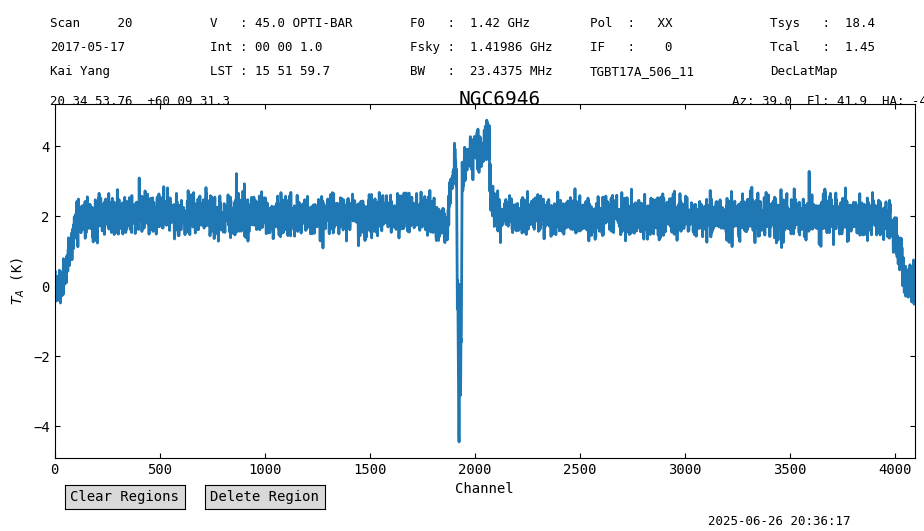

In [9]:
sb[13].calibrated(30).plot(xaxis_unit='channel')
sb[13].calibrated(30).stats()

We will define a timeaveraged spectrum over the full field to provide a model for a baseline subtraction.  

In the resulting spectrum, called `ta` below, we also compute a mean/std/min/max tuple, which can guide you to see
if you get the same answer as we got:

```
          mean                 std                 min               max
STATS: -0.035866831173985356 0.2025869634192485 -4.577272881467833 0.7501954424592066
```


STATS: -0.035866831173985356 0.2025869634192485 -4.577272881467833 0.7501954424592066
Before subtraction: -0.16784998359679254
After  subtraction: -0.1403397153108184


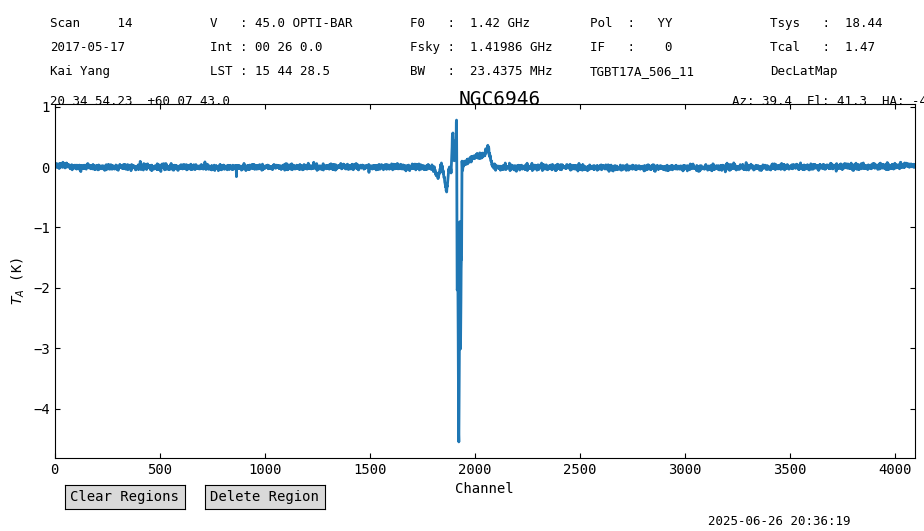

In [10]:
ta = sb.timeaverage()
print(f"STATS: {ta.stats(qac=True)}")
ta.plot(xaxis_unit='channel', ylim=(-1,1))
plt.savefig('otf1_baseline.png')

ta.baseline(1, [(1500,2500)], remove=True)

print('Before subtraction:',np.mean( sb[13]._calibrated[0]))
sb.subtract_baseline(ta.baseline_model)
print('After  subtraction:',np.mean( sb[13]._calibrated[0]))

Although the baseline subtraction did cause a difference, it's a very small difference.   Looking at a spectrum near the center however, shows quite a considerable offset of about 2 K

So clearly something is wrong here.

{'mean': <Quantity 2.00814079 K>,
 'median': <Quantity 2.01980639 K>,
 'rms': <Quantity 0.64029797 K>,
 'min': <Quantity -4.42676719 K>,
 'max': <Quantity 4.77170202 K>}

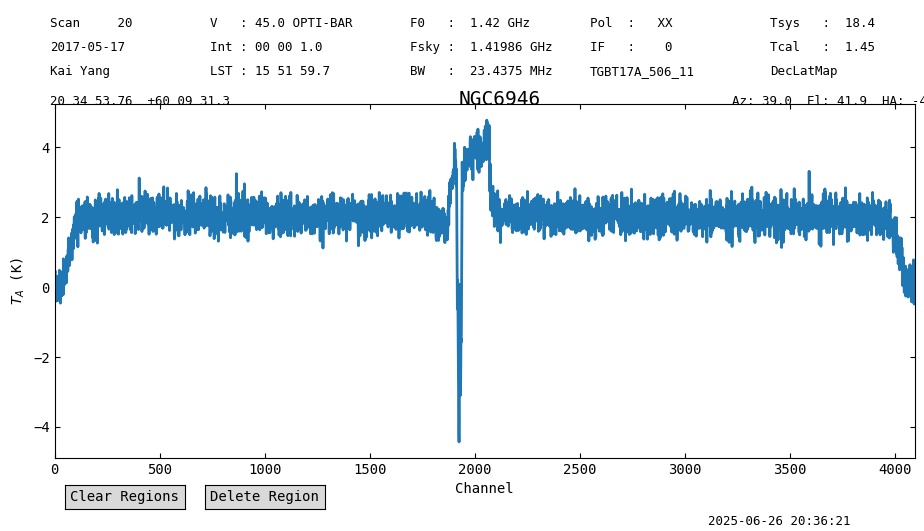

In [11]:
sb[13].calibrated(30).plot(xaxis_unit='channel')
sb[13].calibrated(30).stats()

In [12]:
# write all 1586 calibrated spectra to an SDFITS file

sb.write("otf1_calibrated.fits", overwrite=True)    #  300 ms

## Gridding

The most commonly used task for gridding is `gbtgridder`, but is not part of dysh.  

If you don't have it installed, here's a super short blurb how to get it, with
the note that it is important to get the correct release branch.   This was the situation summer 2025, and it may change, so be sure to be in touch with the developers for recommendations, and surely we update this blurb here as well.

```
      git clone -b release_3.0  https://github.com/GreenBankObservatory/gbtgridder
      pip install -e gbtgridder
```

After installation, either from the shell, or from the notebook, one can grid as follows:

```
      gbtgridder --size 32 32  --channels 500:3500 -o otf1 --clobber --auto otf1.fits
```

this process will create `test2_cube.fits` andd `test2_weight.fits`

In [13]:
!gbtgridder --size 32 32  --channels 500:3500 -o otf1 --clobber --auto otf1.fits

channelString (500:3500)
Loading data ... 
    otf1.fits
existing otf1_cube.fits removed
existing otf1_weight.fits removed
Data Extracted Successfully.

 Please note that this gridding will be done using a monochromatic beam ie. using a single frequency (color) for the convolution kernel. 



 Your parameters were either user specified or assumed to be the following. Please review: 

Name          Value
--------      ---------
Kernel        gauss
Telescope     GBT
Projection    SFL
Input Chan.   499:3499
# Output Chan. 3001
# of spec.    854
Image size    32x32
Beam_FWHM     0.14514580398896607


 Gridding
Running cygrid on the data
Writing cube
Writing weight cube
Runtime: 0.0 minutes


In [14]:
ls -l otf1*

-rw-rw-r-- 1 teuben teuben    48753 Jun 26 20:36 otf1_baseline.png
-rw-rw-r-- 1 teuben teuben 27241920 Jun 26 20:36 otf1_calibrated.fits
-rw-rw-r-- 1 teuben teuben 24592320 Jun 26 20:36 otf1_cube.fits
-rw-rw-r-- 1 teuben teuben 14627520 Jun 18 10:00 otf1.fits
-rw-rw-r-- 1 teuben teuben 72120960 Jun 26 20:36 otf1_small.fits
-rw-rw-r-- 1 teuben teuben 24592320 Jun 26 20:36 otf1_weight.fits


## Viewing the gridded cube

The cube should be a 32 x 32 x 3001 x 1 FITS cube.

@todo Should check if the gridder can handle NAXIS4=2, but dysh may not handle this. Future feature?

In [15]:
from astropy.io import fits


In [16]:
cube = 'otf1_cube.fits'

hdu = fits.open(cube)
header = hdu[0].header
print(header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    4 / number of array dimensions                     NAXIS1  =                   32                                                  NAXIS2  =                   32                                                  NAXIS3  =                 3001                                                  NAXIS4  =                    1                                                  CTYPE1  = 'RA---SFL'                                                            CRVAL1  =              308.675                                                  CRPIX1  =                 16.0                                                  CDELT1  = -0.04838193466298868                                                  CTYPE2  = 'DEC--SFL'                                                            CRVAL2  =                  0.0          

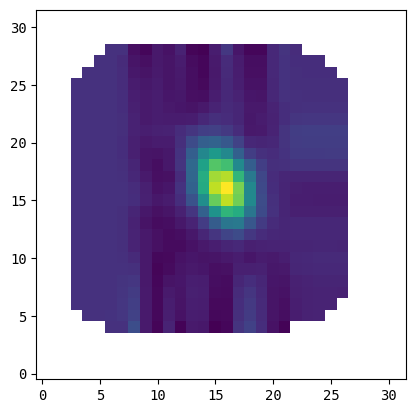

In [17]:
import matplotlib.pyplot as plt

data = hdu[0].data
slice = data[0,1500]
#  no WCS, just quick and dirty.  north is up this way and east to the left
plt.imshow(slice, origin='lower')

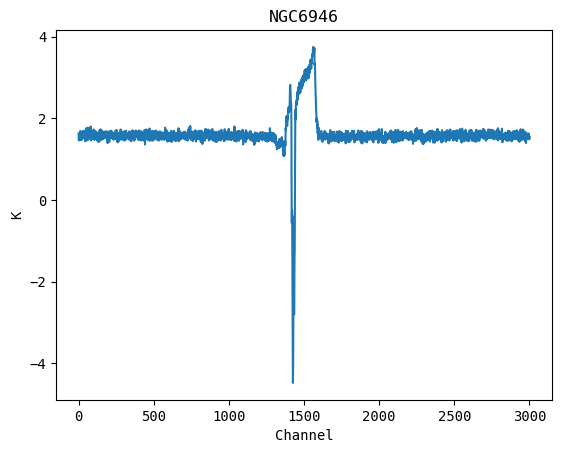

In [18]:
# take a spectrum near to the center

spec = data[0,:,16,16]

plt.plot(spec)
plt.xlabel("Channel")
plt.ylabel(header["BUNIT"])
plt.title(header["OBJECT"]);
plt.savefig('otf-spectrum.png')

Here we see the baseline subtraction "did not work". Why is that? 

Well, the model was derived as an average over the whole cube, but as it turns out, there was only a significant baseline offset very near the center, where NGC6946 is located. The average baseline is not a good model. Not even per scan, but only per integration.

We will thus need to do a more proper baseline subtraction in the final cube, or wait for a dysh function to subtract baselines per row in the scan. The developers version `test_otf.py` is a spyder notebook that shows how this can be done with the current tools.

## Viewing interactively

Here we would be leaving the notebook and using your shell environment. Use at your own risk, the commands have been commented out as not to hang the automated notebook checkers.

A note of caution if you use **CARTA**: the cell needs to remain running while viewing. Kill it with the "interrupt the kernel".

In [19]:
# or go the command line way:

#!ds9 otf1_cube.fits

In [20]:
# careful, carta leaves the cell running as long as you want to view the image After that:  interrupt the kernel.

#!carta otf1_cube.fits